In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 174kB/s 
     |████████████████████████████████| 6.8MB 45.3MB/s 
     |████████████████████████████████| 983kB 26.4MB/s 
     |████████████████████████████████| 266kB 41.0MB/s 
     |████████████████████████████████| 1.9MB 37.6MB/s 
     |████████████████████████████████| 1.2MB 43.4MB/s 
     |████████████████████████████████| 471kB 48.1MB/s 
     |████████████████████████████████| 3.3MB 42.4MB/s 
     |████████████████████████████████| 901kB 45.3MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=e4a594cc325377f2cde9a77d759862cb7f1abf61b5ffcf6ff51e5fb33bd23ea6
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=2fcd4ffd56a4f886dc9aecf89cbf2cf4580bcd21b9f934b663780165aac53646
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import tensorflow as tf
import ktrain
from ktrain import text

drugs = pd.read_csv('/content/Drugs.com reviews.csv')
drugs.head()

,Drug name,Condition,Review,Star rating,Date,Useful vote count
0,A / B Otic,Otitis Media,It numbs the pain. It makes my ear feel heavie...,10,23-Sep-09,20
1,A / B Otic,Otitis Media,These drops helped me so much. I was in severe...,10,27-Mar-09,18
2,A + D Cracked Skin Relief,Bacterial Skin Infection,I have severe cracked skin on my hands. I've ...,10,7-Dec-09,6
3,Abacavir / dolutegravir / lamivudine,HIV Infection,August 8th 2017 tested positive.\r\nViral load...,10,30-Sep-17,3
4,Abacavir / dolutegravir / lamivudine,HIV Infection,"Was diagnosed 8/12/17, began treatment 9/25. I...",5,28-Sep-17,1


In [ ]:
drugs = drugs[drugs.Condition == 'Alcohol Dependence']

In [ ]:
drugs = drugs.reset_index()
drugs = drugs.drop(columns = 'index')

drugs.head()

,Drug name,Condition,Review,Star rating,Date,Useful vote count,length,sentiment,sentiment_analysis
0,Acamprosate,Alcohol Dependence,I&rsquo;m a 43 year old guy living in the uk. ...,10,9-Nov-17,0,779,0.175714,pos
1,Acamprosate,Alcohol Dependence,Apart from a few years where I switched to spe...,10,5-Nov-17,6,482,-0.180612,neg
2,Acamprosate,Alcohol Dependence,I'd been drinking for years and it got very he...,9,28-Oct-17,11,559,-0.051644,neg
3,Acamprosate,Alcohol Dependence,"At the end, I was drinking a fifth of vodka da...",9,3-Sep-17,16,706,-0.020000,neg
4,Acamprosate,Alcohol Dependence,I have been taking this for 3 weeks now follow...,10,24-Aug-17,36,524,0.230556,pos


STEP 1: Look at best and worst rated reviews

In [ ]:
#Week 4 Basic NLP

# examine the class distribution by using the value_counts series method
drugs['Star rating'].value_counts().sort_index()

1      17
2       3
3       8
4       2
5      12
6      11
7      11
8      52
9     120
10    282
Name: Star rating, dtype: int64

In [ ]:
# create a new DataFrame by using the OR condition and the bracket notations
# that only contains the 10-star and 1-star reviews
drugs_best_worst = drugs[(drugs['Star rating']==10) | (drugs['Star rating']==1)]

drugs_best_worst = drugs_best_worst.reset_index()
drugs_best_worst = drugs_best_worst.drop(columns = 'index')
drugs_best_worst.head()


,Drug name,Condition,Review,Star rating,Date,Useful vote count,length,sentiment,sentiment_analysis
0,Acamprosate,Alcohol Dependence,I&rsquo;m a 43 year old guy living in the uk. ...,10,9-Nov-17,0,779,0.175714,pos
1,Acamprosate,Alcohol Dependence,Apart from a few years where I switched to spe...,10,5-Nov-17,6,482,-0.180612,neg
2,Acamprosate,Alcohol Dependence,I have been taking this for 3 weeks now follow...,10,24-Aug-17,36,524,0.230556,pos
3,Acamprosate,Alcohol Dependence,I am just checking in again. I started campra...,10,15-Jul-17,42,610,0.090476,pos
4,Acamprosate,Alcohol Dependence,Absolutely amazing\r\nI am 60 and been a heavy...,10,7-Jun-17,55,795,0.054762,pos


In [ ]:
# examine the shape
drugs_best_worst.shape
# define X and y
X = drugs_best_worst.Review
y = drugs_best_worst['Star rating']
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# examine the object shapes
print(X_train.shape)
print(X_test.shape)

(299, 6)

In [ ]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
# fit and transform on X_train to produce X_train_dtm
X_train_dtm = vect.fit_transform(X_train)
# only transform X_test to produce the X_test_dtm
X_test_dtm = vect.transform(X_test)
# examine the shapes: rows are documents, columns are terms/tokens/features
# 16825 unique terms in 16825 columns learned from the training data
print(X_train_dtm.shape)
print(X_test_dtm.shape)
# examine the last 50 features
print(vect.get_feature_names()[-50:])

(224, 2098)
(75, 2098)
['wings', 'wise', 'wish', 'wishes', 'with', 'withdrawal', 'withdrawals', 'within', 'without', 'witnessing', 'woke', 'women', 'won', 'wonder', 'wonderful', 'wonderfully', 'wonders', 'word', 'words', 'wore', 'work', 'worked', 'working', 'works', 'world', 'worried', 'worry', 'worrying', 'worse', 'worth', 'would', 'wouldn', 'wreckless', 'write', 'writing', 'wrong', 'wrote', 'yak', 'yay', 'year', 'years', 'yesterday', 'you', 'youngest', 'your', 'yourself', 'youtube', 'yrs', 'zero', 'zone']


In [ ]:
y_test.value_counts().head(1) / y_test.shape
y_test.value_counts()

10    71
1      4
Name: Star rating, dtype: int64

In [ ]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict the star rating
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)

    nb.predict_proba(X_test_dtm)
    y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
    
    # print the accuracy of its predictions from the metrics module
    #pass it to the true values and the predicted values.
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('ROC AUC Score: ' ,metrics.roc_auc_score(y_test, y_pred_prob))

In [ ]:
#assess how good is it to use the default paramters.
tokenize_test(vect) #pass it to this function
#Accuracy:  0.8853122033758408
#ROC AUC Score:  0.9361159567902227

Features:  2098
Accuracy:  0.9733333333333334
ROC AUC Score:  0.6866197183098591


PART 2: sentiment analysis

In [ ]:
#week 5 TF-IDF and sentiment analysis

vect2 = TfidfVectorizer(stop_words='english')
dtm = vect2.fit_transform(drugs.Review)
dtm.shape

# create a list of all of the features
features = vect2.get_feature_names()
len(features)

2719

In [ ]:
#print the first review
print(drugs.loc[0, 'Review'])

I&rsquo;m a 43 year old guy living in the uk. I&rsquo;ve been a regular big drinker since the age of 24.  Always liked the buzz I got off drinking, always drank till I was totally out of it. 
Done drink driving four times, the last time I should have been banged up but somehow got away with it, bolloxed up a few relationships along the way through it. In the early years it was fun but it&rsquo;s destroyed and damaged the last 10 years of my life. Currently in a relationship with someone I love very much and respect a great deal, I&rsquo;m doing this for both of us. My GP wouldn&rsquo;t
prescribe so going through a referred clinic to get campral after hearing all these uplifting sucess stories from people. Hope it works for me as it did for you. Getting it this Friday


In [ ]:
# save it as a TextBlob object
review = TextBlob(drugs.loc[0, 'Review'])

In [ ]:
# examine the words
nltk.download('punkt')
review.words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordList(['I', 'rsquo', 'm', 'a', '43', 'year', 'old', 'guy', 'living', 'in', 'the', 'uk', 'I', 'rsquo', 've', 'been', 'a', 'regular', 'big', 'drinker', 'since', 'the', 'age', 'of', '24', 'Always', 'liked', 'the', 'buzz', 'I', 'got', 'off', 'drinking', 'always', 'drank', 'till', 'I', 'was', 'totally', 'out', 'of', 'it', 'Done', 'drink', 'driving', 'four', 'times', 'the', 'last', 'time', 'I', 'should', 'have', 'been', 'banged', 'up', 'but', 'somehow', 'got', 'away', 'with', 'it', 'bolloxed', 'up', 'a', 'few', 'relationships', 'along', 'the', 'way', 'through', 'it', 'In', 'the', 'early', 'years', 'it', 'was', 'fun', 'but', 'it', 'rsquo', 's', 'destroyed', 'and', 'damaged', 'the', 'last', '10', 'years', 'of', 'my', 'life', 'Currently', 'in', 'a', 'relationship', 'with', 'someone', 'I', 'love', 'very', 'much', 'and', 'respect', 'a', 'great', 'deal', 'I', 'rsquo', 'm', 'doing', 'this', 'for', 'both', 'of', 'us', 'My', 'GP', 'wouldn', 'rsquo', 't', 'prescribe', 'so', 'going', 'through', 'a',

In [ ]:
# examine the sentences
review.sentences

[Sentence("I&rsquo;m a 43 year old guy living in the uk."),
 Sentence("I&rsquo;ve been a regular big drinker since the age of 24."),
 Sentence("Always liked the buzz I got off drinking, always drank till I was totally out of it."),
 Sentence("Done drink driving four times, the last time I should have been banged up but somehow got away with it, bolloxed up a few relationships along the way through it."),
 Sentence("In the early years it was fun but it&rsquo;s destroyed and damaged the last 10 years of my life."),
 Sentence("Currently in a relationship with someone I love very much and respect a great deal, I&rsquo;m doing this for both of us."),
 Sentence("My GP wouldn&rsquo;t
 prescribe so going through a referred clinic to get campral after hearing all these uplifting sucess stories from people."),
 Sentence("Hope it works for me as it did for you."),
 Sentence("Getting it this Friday")]

In [ ]:
#examine the review sentiment
print(review.sentiment.polarity)
print(review.sentiment.subjectivity)

0.1757142857142857
0.3335897435897436


In [ ]:
#add length column to the dataframe.
drugs['length'] = drugs.Review.apply(len)
drugs.head()

,Drug name,Condition,Review,Star rating,Date,Useful vote count,length,sentiment,sentiment_analysis
0,Acamprosate,Alcohol Dependence,I&rsquo;m a 43 year old guy living in the uk. ...,10,9-Nov-17,0,779,0.175714,pos
1,Acamprosate,Alcohol Dependence,Apart from a few years where I switched to spe...,10,5-Nov-17,6,482,-0.180612,neg
2,Acamprosate,Alcohol Dependence,I'd been drinking for years and it got very he...,9,28-Oct-17,11,559,-0.051644,neg
3,Acamprosate,Alcohol Dependence,"At the end, I was drinking a fifth of vodka da...",9,3-Sep-17,16,706,-0.020000,neg
4,Acamprosate,Alcohol Dependence,I have been taking this for 3 weeks now follow...,10,24-Aug-17,36,524,0.230556,pos


In [ ]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    
    #Converts the text into textblob object and then retuns
    #the polarity.
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity

In [ ]:
# create a new DataFrame column for sentiment
drugs['sentiment'] = drugs.Review.apply(detect_sentiment)

In [ ]:
drugs.head()

,Drug name,Condition,Review,Star rating,Date,Useful vote count,length,sentiment,sentiment_analysis
0,Acamprosate,Alcohol Dependence,I&rsquo;m a 43 year old guy living in the uk. ...,10,9-Nov-17,0,779,0.175714,pos
1,Acamprosate,Alcohol Dependence,Apart from a few years where I switched to spe...,10,5-Nov-17,6,482,-0.180612,neg
2,Acamprosate,Alcohol Dependence,I'd been drinking for years and it got very he...,9,28-Oct-17,11,559,-0.051644,neg
3,Acamprosate,Alcohol Dependence,"At the end, I was drinking a fifth of vodka da...",9,3-Sep-17,16,706,-0.020000,neg
4,Acamprosate,Alcohol Dependence,I have been taking this for 3 weeks now follow...,10,24-Aug-17,36,524,0.230556,pos


In [ ]:
list_sentiment = []
for x in drugs['sentiment'] :
  if x > 0 :
    list_sentiment.append('pos')
  elif x <= 0 :
    list_sentiment.append('neg')

drugs['sentiment_analysis'] = list_sentiment

In [ ]:
drugs.groupby('Drug name').sum()

#Acamprosate has highest sentiment based on total

,Star rating,Useful vote count,length,sentiment
Drug name,,,,
Acamprosate,1268,8960,65389,11.980374
Antabuse,441,4571,26396,4.054201
Campral,1099,8597,55887,11.794915
Disulfiram,529,4714,31258,3.721831
Naltrexone,1053,7724,63318,8.989260
Ondansetron,7,7,651,0.168993
Revia,46,771,1674,0.698283
Vivitrol,131,1433,6531,-0.005108


In [ ]:
drugs.groupby('Drug name').mean()

#Ondansetron has the highest sentiment based on mean
#however, Revia has the second highest sentiment and has the highest star rating based on mean

,Star rating,Useful vote count,length,sentiment
Drug name,,,,
Acamprosate,8.867133,62.657343,457.265734,0.083779
Antabuse,9.000000,93.285714,538.693878,0.082739
Campral,9.008197,70.467213,458.090164,0.096680
Disulfiram,8.672131,77.278689,512.426230,0.061014
Naltrexone,8.631148,63.311475,519.000000,0.073682
Ondansetron,7.000000,7.000000,651.000000,0.168993
Revia,9.200000,154.200000,334.800000,0.139657
Vivitrol,8.733333,95.533333,435.400000,-0.000341


In [ ]:
#Acamprosate dataset for visuals

Acamprosate = drugs[drugs['Drug name'] == 'Acamprosate']
Acamprosate.head()

,Drug name,Condition,Review,Star rating,Date,Useful vote count,length,sentiment,sentiment_analysis
0,Acamprosate,Alcohol Dependence,I&rsquo;m a 43 year old guy living in the uk. ...,10,9-Nov-17,0,779,0.175714,pos
1,Acamprosate,Alcohol Dependence,Apart from a few years where I switched to spe...,10,5-Nov-17,6,482,-0.180612,neg
2,Acamprosate,Alcohol Dependence,I'd been drinking for years and it got very he...,9,28-Oct-17,11,559,-0.051644,neg
3,Acamprosate,Alcohol Dependence,"At the end, I was drinking a fifth of vodka da...",9,3-Sep-17,16,706,-0.020000,neg
4,Acamprosate,Alcohol Dependence,I have been taking this for 3 weeks now follow...,10,24-Aug-17,36,524,0.230556,pos


In [ ]:
#Revia dataset for visuals

Revia = drugs[drugs['Drug name'] == 'Revia']
Revia.head()

,Drug name,Condition,Review,Star rating,Date,Useful vote count,length,sentiment,sentiment_analysis
498,Revia,Alcohol Dependence,"it works very well, it's a good friend. I have...",9,4-Jun-15,98,159,0.333333,pos
499,Revia,Alcohol Dependence,I do not obsess over alcohol like I used to. O...,10,21-Aug-13,151,237,-0.062500,neg
500,Revia,Alcohol Dependence,I have never slept so well or had any withdraw...,9,20-Nov-11,152,583,0.132500,pos
501,Revia,Alcohol Dependence,I spent nearly a decade of my life in and out ...,10,13-Oct-08,219,479,0.094949,pos
502,Revia,Alcohol Dependence,totally took the craving for alcohol away. ke...,8,29-Apr-08,151,216,0.200000,pos


STEP 3: VISUALS

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


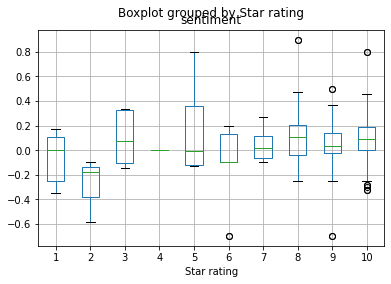

In [ ]:
#Boxplot of sentiment grouped by star rating
%matplotlib inline
drugs.boxplot('sentiment', by='Star rating')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


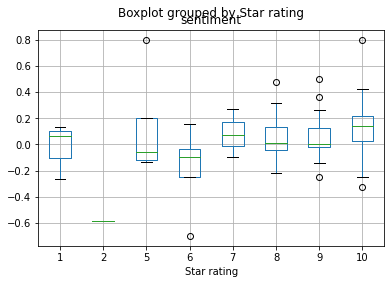

In [ ]:
#Acamprosate boxplot

Acamprosate.boxplot('sentiment', by='Star rating')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


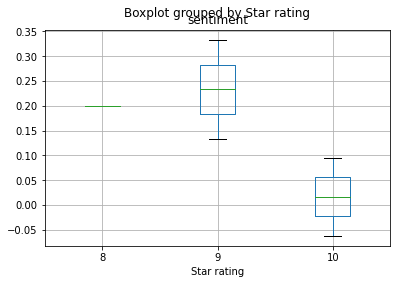

In [ ]:
#Revia boxplot

Revia.boxplot('sentiment', by='Star rating')

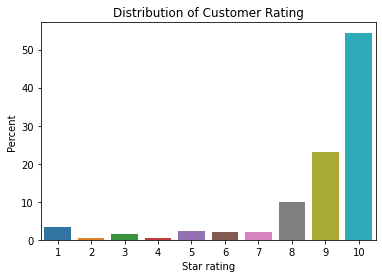

In [ ]:
#distribution of customer rating
ax = sns.barplot(data=drugs, x='Star rating', y='Star rating', estimator=lambda x: len(x) / len(drugs) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating for All Drugs')
plt.show()

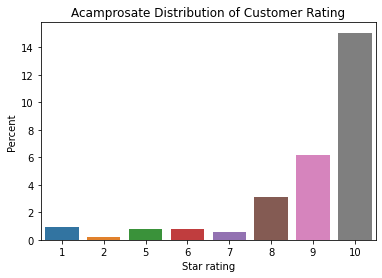

In [ ]:
# Acamprosate distribution of customer rating

ax = sns.barplot(data=Acamprosate, x='Star rating', y='Star rating', estimator=lambda x: len(x) / len(drugs) * 100)
ax.set(ylabel="Percent")
plt.title('Acamprosate Distribution of Customer Rating')
plt.show()

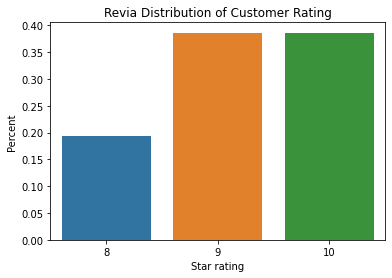

In [ ]:
# Revia distribution of customer rating

ax = sns.barplot(data=Revia, x='Star rating', y='Star rating', estimator=lambda x: len(x) / len(drugs) * 100)
ax.set(ylabel="Percent")
plt.title('Revia Distribution of Customer Rating')
plt.show()

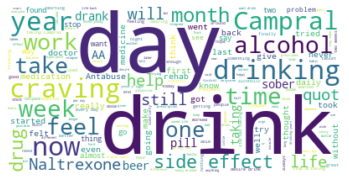

In [ ]:
# concatenate all the reviews into one single string 
full_text = ' '.join(drugs['Review'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

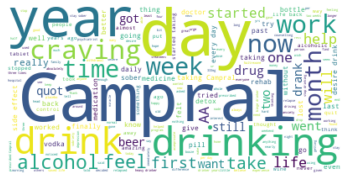

In [ ]:
# concatenate all the reviews into one single string 
full_text = ' '.join(Acamprosate['Review'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

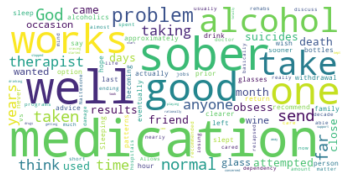

In [ ]:
# concatenate all the reviews into one single string 
full_text = ' '.join(Revia['Review'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

STEP 4: BERT

In [ ]:
from sklearn.model_selection import train_test_split
drugs_train, drugs_test = train_test_split(drugs, test_size=0.25)

In [ ]:
#Sentiment training with BERT
#call the text module from the ktrain to read the data
(X_train, y_train), (X_test, y_test), preprocess = text.texts_from_df(train_df= drugs_train, text_column= 'Review', label_columns= 'sentiment_analysis',
                   val_df = drugs_test, maxlen= 400, preprocess_mode= 'bert')

NameError: ignored

In [ ]:
model = text.text_classifier(name='bert', train_data= (X_train, y_train),
                             preproc = preprocess)

Is Multi-Label? False
maxlen is 400
done.


In [ ]:
learner = ktrain.get_learner(model= model, train_data= (X_train, y_train),
                             val_data= (X_test, y_test),
                             batch_size= 6)

In [ ]:
predictor = ktrain.get_predictor(learner.model, preprocess)

In [ ]:
data = ["this drug made me tired"]

In [ ]:
data2 = ["this drug made me sick"]

In [ ]:
data3 = ["this drug worked for me"]

In [ ]:
data4 = ["this drug helped me"]

In [ ]:
predictor.predict(data2)

In [ ]:
predictor.predict(data)

['neg']